In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set(style='whitegrid')

c:\Users\jimen\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Carga de Datos

In [2]:
ruta_excel = r"C:\Users\jimen\Desktop\Marsh Mclennan\2023 Budget FX Rates.xlsx"
ruta_csv = r"C:\Users\jimen\Desktop\Marsh Mclennan\Años\consolidated_data_2024.csv"
ruta_dic_pais = r"C:\Users\jimen\Desktop\Marsh Mclennan\dic_pais.xlsx"

In [3]:
def cargar_datos(ruta_excel, ruta_csv, ruta_dic_pais):
    df_excel = pd.read_excel(ruta_excel, engine='openpyxl')
    df_csv = pd.read_csv(ruta_csv)
    df_dic_pais = pd.read_excel(ruta_dic_pais, sheet_name='dic_pais_2', engine='openpyxl')
    
    return df_excel, df_csv, df_dic_pais

df_excel, df_csv, df_dic_pais = cargar_datos(ruta_excel, ruta_csv, ruta_dic_pais)

Transformación de Datos

In [12]:
def preparar_datos(df_excel, df_csv, df_dic_pais):
    # Renombrar columna para hacer el merge
    df_excel.rename(columns={"CURR CODE": "Currency"}, inplace=True)
    
    # Hacer el merge usando la columna "Currency" como referencia
    df_merged = pd.merge(df_csv, df_excel[['Currency', 'BUDGET RATE']], on='Currency', how='left')
    
    # Convertir transacciones a USD
    df_merged['Transaction_USD'] = df_merged['Transaction'] * df_merged['BUDGET RATE']
    
    # Hacer merge para añadir la información de región y continente
    df_merged = pd.merge(df_merged, df_dic_pais[['Country', 'Region', 'Continent']], on='Country', how='left')
    
    return df_merged
df_merged = preparar_datos(df_excel, df_csv, df_dic_pais)


In [13]:
df_merged.head()

,Client,Country,Currency,Transaction,date,BUDGET RATE,Transaction_USD,Region,Continent
0,FLVWa,FIJI,MWK,1626847.37,2024-01-04,0.000974,1585.232614,Oceanía,Oceanía
1,FLVWa,GUYANA,LAK,44546375.72,2024-01-04,0.000058,2603.290197,América Latina,América del Sur
2,FLVWa,BAHAMAS,MMK,1758344.03,2024-01-04,0.000476,837.305844,Caribe,América del Norte
3,EKKL3,BOTSWANA,TWD,34098.47,2024-01-04,0.032055,1093.039754,África Subsahariana,África
4,EKKL3,OMAN,CLP,54075.56,2024-01-04,0.001053,56.921557,Oriente Medio,Asia


Estadisticas Y Visualización

Estadísticas descriptivas por Región:
                       count         mean           std          min  \
Region                                                                 
América Latina       43499.0  6740.936794  11191.990315 -1032.774073   
América del Norte     4496.0  6658.430584  10662.328034  -434.399183   
Asia Central          4561.0  6690.456524  10734.354639  -644.946916   
Asia Oriental        13822.0  6767.877355  11183.211236  -542.954332   
Asia del Sur         16212.0  6685.738708  11208.210438 -1597.155834   
Caribe               25469.0  6815.179563  11092.961724  -701.814560   
Europa Central        9175.0  6942.177504  11304.928769 -1505.484184   
Europa Occidental     2323.0  6414.248133   9529.056429  -282.586669   
Europa del Este      20651.0  6581.065884  11002.944806  -786.702538   
Europa del Norte     11617.0  6627.550552  10797.747178  -951.053315   
Oceanía              20576.0  6872.469459  11792.164600  -674.302587   
Oriente Medio        32029

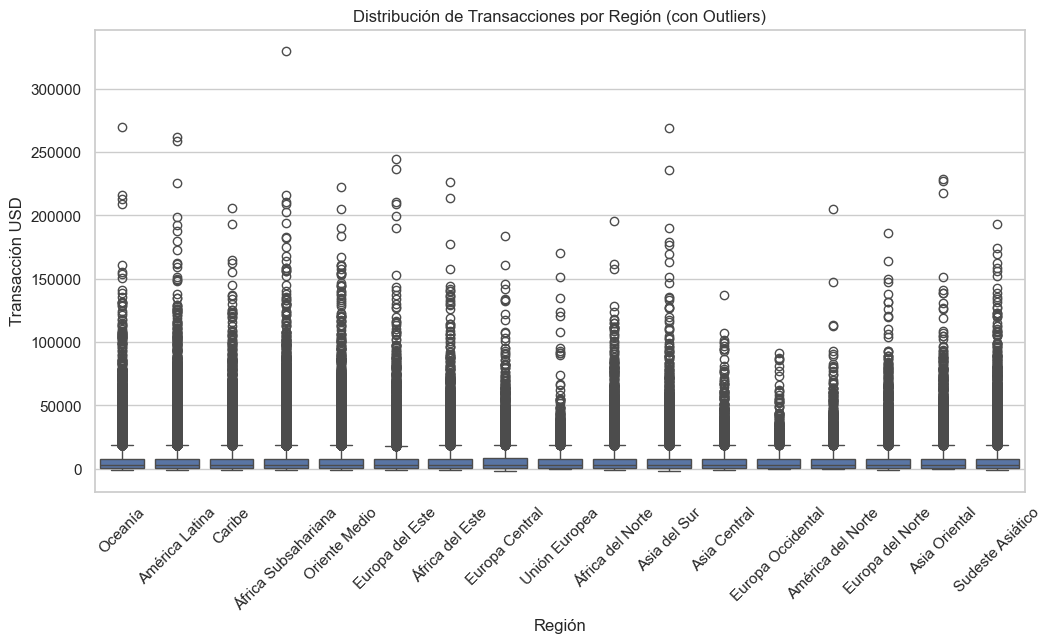

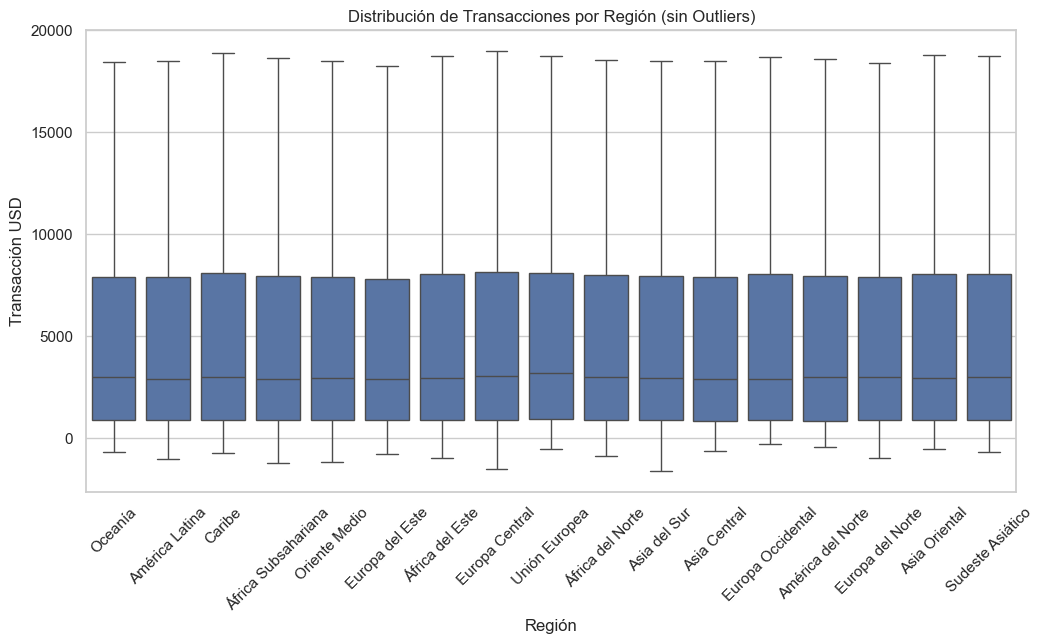

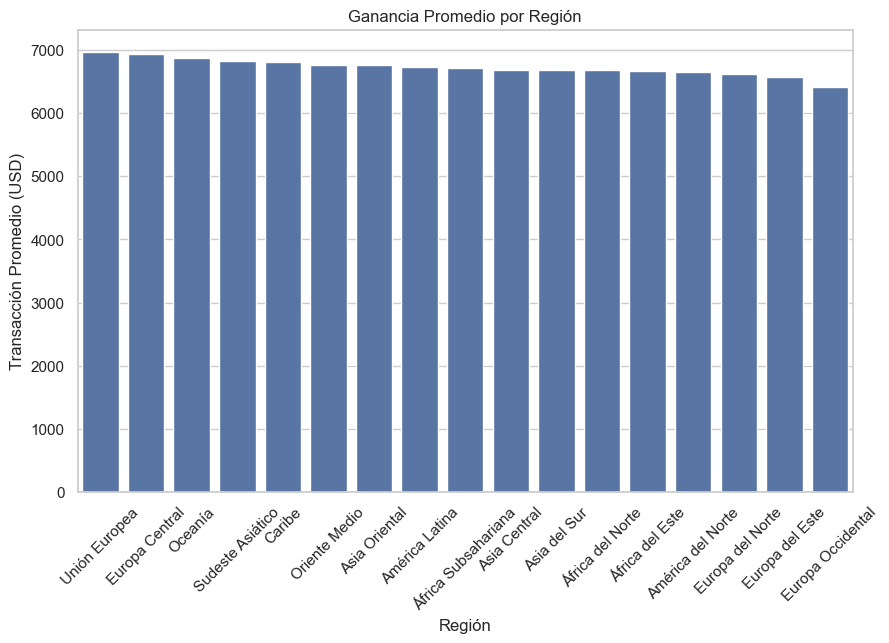

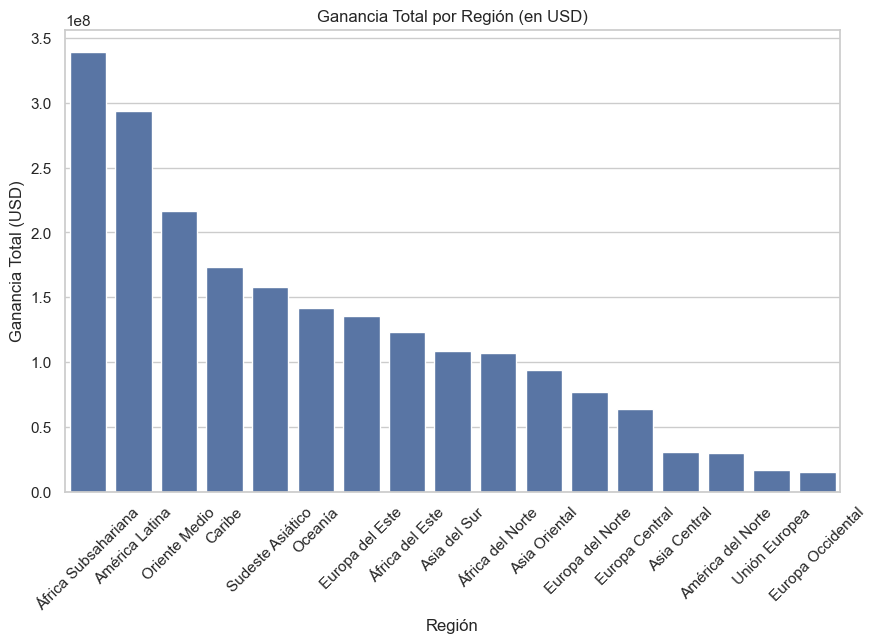

In [6]:
def estadisticas_descriptivas(df):
    # Estadísticas descriptivas por Región
    region_stats = df.groupby('Region')['Transaction_USD'].describe()
    print("Estadísticas descriptivas por Región:")
    print(region_stats)

    # Gráfico de boxplot (con y sin outliers) para Región
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Region', y='Transaction_USD', data=df)
    plt.title('Distribución de Transacciones por Región (con Outliers)')
    plt.xlabel('Región')
    plt.ylabel('Transacción USD')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Region', y='Transaction_USD', data=df, showfliers=False)
    plt.title('Distribución de Transacciones por Región (sin Outliers)')
    plt.xlabel('Región')
    plt.ylabel('Transacción USD')
    plt.xticks(rotation=45)
    plt.show()

    # Gráfico de barras para Ganancia Promedio y Ganancia Total por Región
    avg_transaction_region = df.groupby('Region')['Transaction_USD'].mean().sort_values(ascending=False)
    total_transaction_region = df.groupby('Region')['Transaction_USD'].sum().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_transaction_region.index, y=avg_transaction_region.values)
    plt.title('Ganancia Promedio por Región')
    plt.xlabel('Región')
    plt.ylabel('Transacción Promedio (USD)')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=total_transaction_region.index, y=total_transaction_region.values)
    plt.title('Ganancia Total por Región (en USD)')
    plt.xlabel('Región')
    plt.ylabel('Ganancia Total (USD)')
    plt.xticks(rotation=45)
    plt.show()

estadisticas_descriptivas(df_merged)

Prueba ANOVA

In [7]:
def realizar_anova(df):
    # Ajustar el modelo usando Ordinary Least Squares (OLS) con 'Region'
    anova_model = ols('Transaction_USD ~ C(Region)', data=df).fit()

    # Realizar la prueba ANOVA
    anova_table = sm.stats.anova_lm(anova_model, typ=2)
    print("Resultados de la prueba ANOVA:")
    print(anova_table)

realizar_anova(df_merged)


Resultados de la prueba ANOVA:
                 sum_sq        df         F    PR(>F)
C(Region)  2.406513e+09      16.0  1.210582  0.249986
Residual   3.910406e+13  314737.0       NaN       NaN


Regresión Lineal

In [8]:
def realizar_regresion(df):
    # Convertir 'Region' a variables dummy
    df_dummies = pd.get_dummies(df['Region'], drop_first=True)

    # Definir la variable dependiente (y) y las independientes (X)
    y = df['Transaction_USD']
    X = df_dummies

    # Concatenar X e y en un nuevo DataFrame para eliminar NaN
    df_for_regression = pd.concat([X, y], axis=1)
    df_for_regression = df_for_regression.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
    df_for_regression = df_for_regression.dropna()

    # Actualizar X e y sin valores NaN
    X = df_for_regression[df_dummies.columns]
    y = df_for_regression['Transaction_USD']

    # Añadir un término constante a X para la regresión (esto es el intercepto)
    X = sm.add_constant(X)

    # Ajustar el modelo de regresión lineal
    try:
        regression_model = sm.OLS(y, X).fit()

        # Mostrar los resultados del modelo de regresión lineal
        print("Resultados de la regresión lineal:")
        print(regression_model.summary())

    except ValueError as e:
        print(f"Error en el ajuste del modelo: {e}")

realizar_regresion(df_merged)

Resultados de la regresión lineal:
                            OLS Regression Results                            
Dep. Variable:        Transaction_USD   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.211
Date:                Mon, 18 Nov 2024   Prob (F-statistic):              0.250
Time:                        12:10:45   Log-Likelihood:            -3.3798e+06
No. Observations:              314754   AIC:                         6.760e+06
Df Residuals:                  314737   BIC:                         6.760e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

ANALISIS CONTINENTES

Estadiscas y Visualización

Estadísticas descriptivas por Continente:
                     count         mean           std          min  \
Continent                                                            
América del Norte  46045.0  6768.440417  10968.220352  -755.045674   
América del Sur    27419.0  6750.183551  11385.992323 -1032.774073   
Asia               89684.0  6766.703592  11242.433931 -1597.155834   
Europa             46124.0  6676.375616  10986.918976 -1505.484184   
Oceanía            20576.0  6872.469459  11792.164600  -674.302587   
África             84906.0  6705.231806  10986.401316 -1215.210815   

                          25%          50%          75%            max  
Continent                                                               
América del Norte  870.080000  2954.532866  8051.049663  205671.919200  
América del Sur    883.237650  2921.962303  7884.564545  261639.920893  
Asia               874.669060  2966.646710  7972.235802  268870.679005  
Europa             893.201274  2

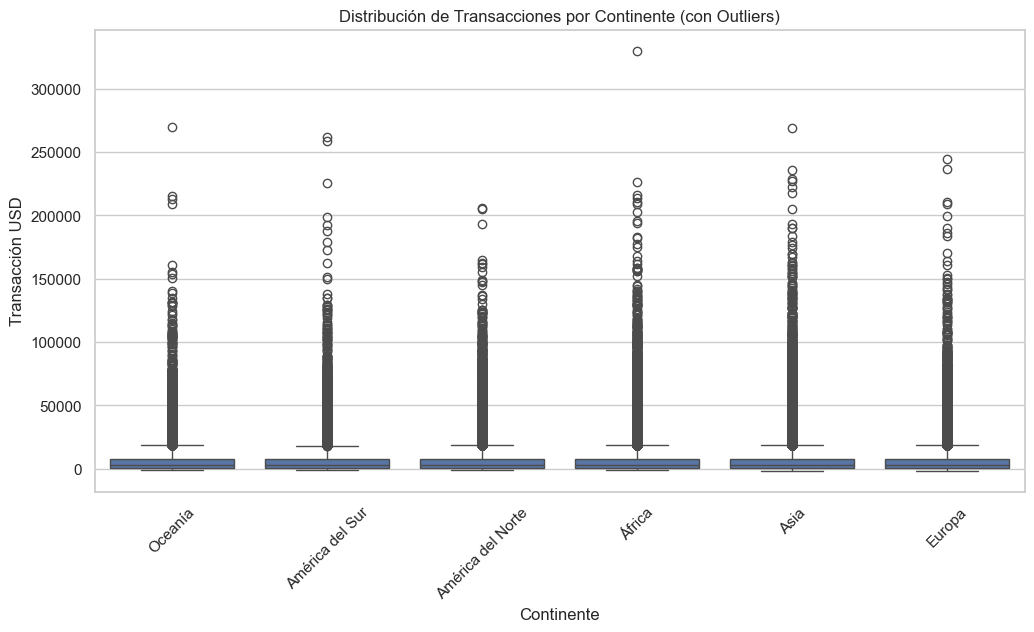

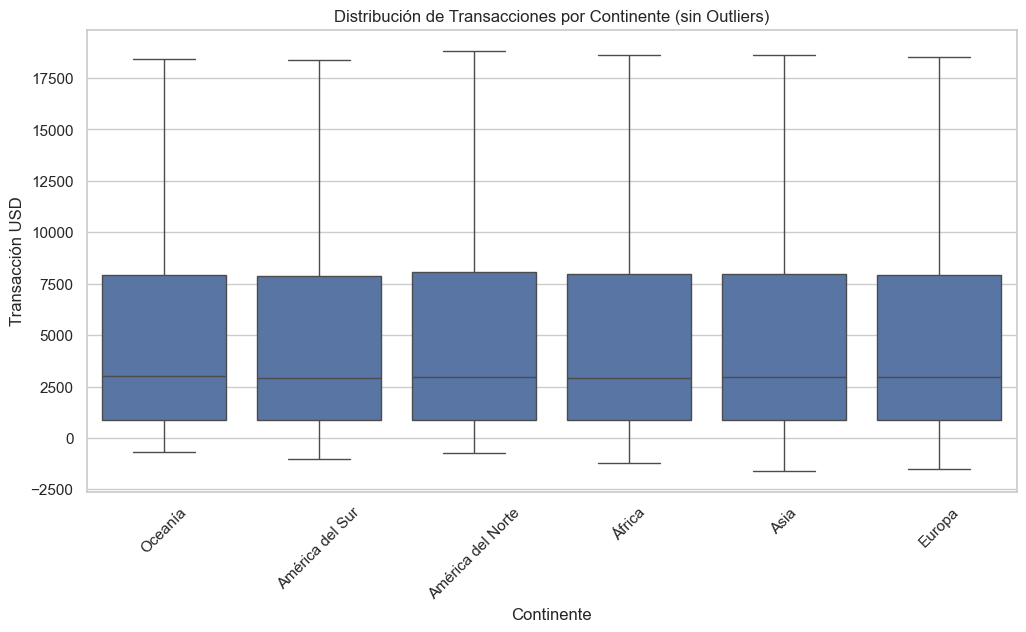

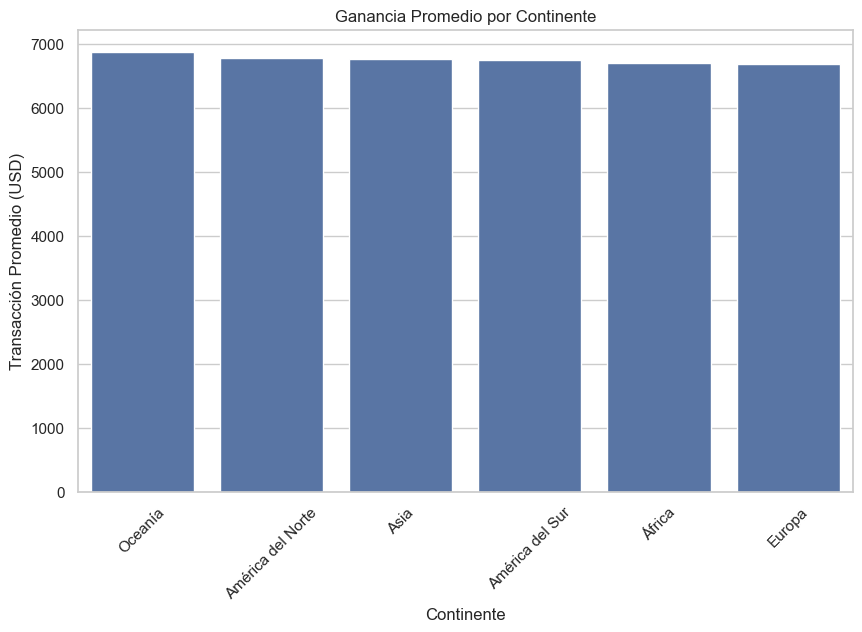

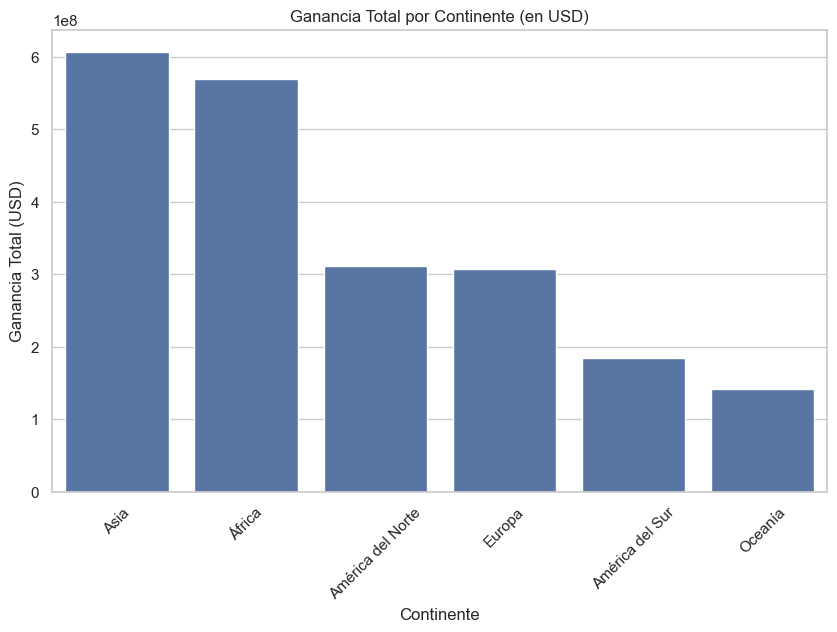

In [9]:
def estadisticas_descriptivas(df):
    # Estadísticas descriptivas por Continente
    continent_stats = df.groupby('Continent')['Transaction_USD'].describe()
    print("Estadísticas descriptivas por Continente:")
    print(continent_stats)

    # Gráfico de boxplot (con y sin outliers) para Continente
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Continent', y='Transaction_USD', data=df)
    plt.title('Distribución de Transacciones por Continente (con Outliers)')
    plt.xlabel('Continente')
    plt.ylabel('Transacción USD')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Continent', y='Transaction_USD', data=df, showfliers=False)
    plt.title('Distribución de Transacciones por Continente (sin Outliers)')
    plt.xlabel('Continente')
    plt.ylabel('Transacción USD')
    plt.xticks(rotation=45)
    plt.show()

    # Gráfico de barras para Ganancia Promedio y Ganancia Total por Continente
    avg_transaction_continent = df.groupby('Continent')['Transaction_USD'].mean().sort_values(ascending=False)
    total_transaction_continent = df.groupby('Continent')['Transaction_USD'].sum().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_transaction_continent.index, y=avg_transaction_continent.values)
    plt.title('Ganancia Promedio por Continente')
    plt.xlabel('Continente')
    plt.ylabel('Transacción Promedio (USD)')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=total_transaction_continent.index, y=total_transaction_continent.values)
    plt.title('Ganancia Total por Continente (en USD)')
    plt.xlabel('Continente')
    plt.ylabel('Ganancia Total (USD)')
    plt.xticks(rotation=45)
    plt.show()

estadisticas_descriptivas(df_merged)

Prueba Anova

In [10]:
def realizar_anova(df):
    # Ajustar el modelo usando Ordinary Least Squares (OLS) con 'Continent'
    anova_model = ols('Transaction_USD ~ C(Continent)', data=df).fit()

    # Realizar la prueba ANOVA
    anova_table = sm.stats.anova_lm(anova_model, typ=2)
    print("Resultados de la prueba ANOVA:")
    print(anova_table)

realizar_anova(df_merged)

Resultados de la prueba ANOVA:
                    sum_sq        df         F  PR(>F)
C(Continent)  7.523094e+08       5.0  1.211014  0.3009
Residual      3.910571e+13  314748.0       NaN     NaN


Regresión Lineal

In [11]:
def realizar_regresion(df):
    # Convertir 'Continent' a variables dummy
    df_dummies = pd.get_dummies(df['Continent'], drop_first=True)

    # Definir la variable dependiente (y) y las independientes (X)
    y = df['Transaction_USD']
    X = df_dummies

    # Concatenar X e y en un nuevo DataFrame para eliminar NaN
    df_for_regression = pd.concat([X, y], axis=1)
    df_for_regression = df_for_regression.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)
    df_for_regression = df_for_regression.dropna()

    # Actualizar X e y sin valores NaN
    X = df_for_regression[df_dummies.columns]
    y = df_for_regression['Transaction_USD']

    # Añadir un término constante a X para la regresión (esto es el intercepto)
    X = sm.add_constant(X)

    # Ajustar el modelo de regresión lineal
    try:
        regression_model = sm.OLS(y, X).fit()

        # Mostrar los resultados del modelo de regresión lineal
        print("Resultados de la regresión lineal:")
        print(regression_model.summary())

    except ValueError as e:
        print(f"Error en el ajuste del modelo: {e}")

realizar_regresion(df_merged)

Resultados de la regresión lineal:
                            OLS Regression Results                            
Dep. Variable:        Transaction_USD   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.211
Date:                Mon, 18 Nov 2024   Prob (F-statistic):              0.301
Time:                        12:10:48   Log-Likelihood:            -3.3798e+06
No. Observations:              314754   AIC:                         6.760e+06
Df Residuals:                  314748   BIC:                         6.760e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const  